In [ ]:
#| default_exp drone

In [ ]:
#| include: false
from fastcore.all import *
import plotly.io as pio

In [ ]:
#| export
import math
import numpy as np
import plotly.express as px
import pandas as pd
import gtsam
import torch
from dataclasses import dataclass

In [ ]:
#| include: false
pio.renderers.default = "png"

## Coordinate Frames


In [ ]:
#| export
def axes_figure(pose: gtsam.Pose3, scale: float = 1.0, labels: list = ["X", "Y", "Z"]):
    """Create plotly express figure with Pose3 coordinate frame."""
    t = np.reshape(pose.translation(),(3,1))
    M = np.hstack([t,t,t,pose.rotation().matrix() * scale + t])
    df = pd.DataFrame({"x": M[0], "y": M[1], "z": M[2]}, labels+labels)
    return px.line_3d(df, x="x", y="y", z="z", color=df.index,
                     color_discrete_sequence=["red", "green", "blue"])

def axes(*args, **kwargs):
    """Create 3 Scatter3d traces representing Pose3 coordinate frame."""
    return axes_figure(*args, **kwargs).data

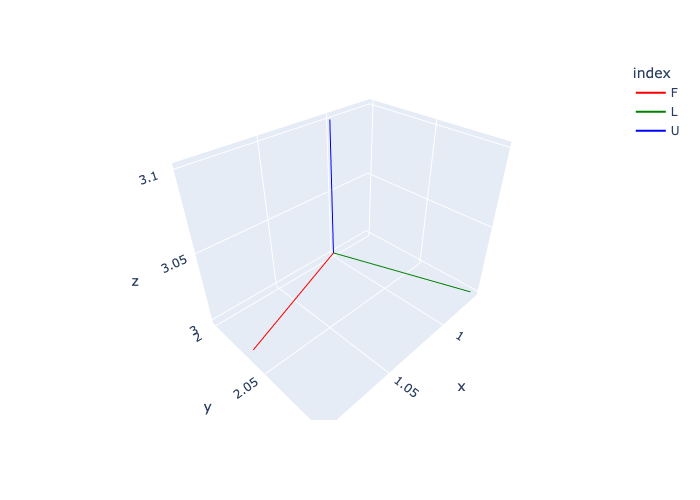

In [ ]:
axes_figure(gtsam.Pose3(gtsam.Rot3.Yaw(math.radians(20)), [1,2,3]), scale=0.1, labels=["F","L","U"])

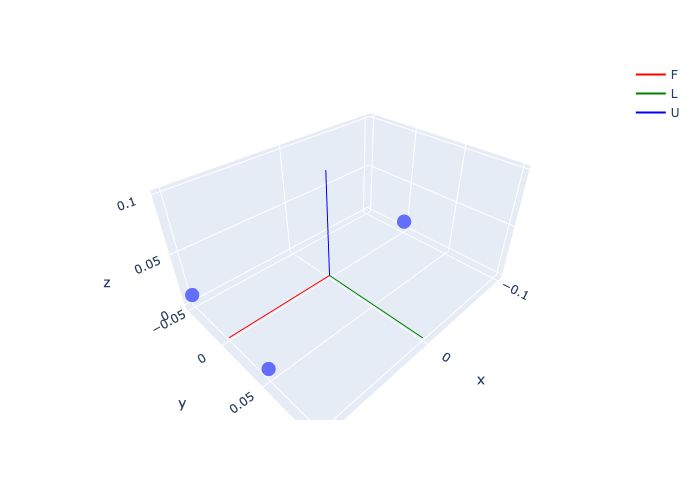

In [ ]:
t1 = gtsam.Point3(0.1, 0.05, 0.01) # front-left
t2 = gtsam.Point3(0.1,-0.05, 0.01) # front-right
t3 = gtsam.Point3(-0.1, 0, 0.01) # back
fig = px.scatter_3d(x=[t1[0], t2[0], t3[0]], y=[t1[1], t2[1], t3[1]], z=[t1[2], t2[2], t3[2]])
fig.add_traces(axes(gtsam.Pose3(), scale=0.1, labels=["F","L","U"]))
fig.show()

## Obstacle Maps

An obstacle map:

In [ ]:
#| export
def create_random_map(W, H, num_obstacles=50, seed=42):
    """
    Creates a random occupancy map with the given dimensions and number of obstacles.
    Optionally, a seed can be provided to make the map reproducible.
    """
    # Set the seed for reproducibility:
    rng = np.random.default_rng(seed=seed)

    # Map dimensions in pixels (10 cm per pixel)
    pixel_W, pixel_H = 10*W, 10*H

    # Initialize an empty occupancy map
    obstacles = torch.zeros((pixel_H, pixel_W), dtype=torch.float32)

    # Add obstacles
    for _ in range(num_obstacles):
        # Random position for the obstacle
        x, y = rng.integers(0, pixel_W), rng.integers(0, pixel_H)

        # Random value for the obstacle (higher than empty space)
        obstacle_value = rng.random() * 0.5 + 0.5  # Random value between 0.5 and 1.0

        # Assign the value to the obstacle position
        obstacles[y, x] = obstacle_value

    # Define a box filter (kernel)
    kernel_size = 5  # The size of the box filter
    kernel = torch.ones((kernel_size, kernel_size), dtype=torch.float32)

    # Apply 2D convolution to "fatten" the objects
    batch = obstacles[None, None, ...]  # Add batch and channel dimensions
    return torch.conv2d(batch, kernel[None, None, ...], padding='same')[0, 0, ...]

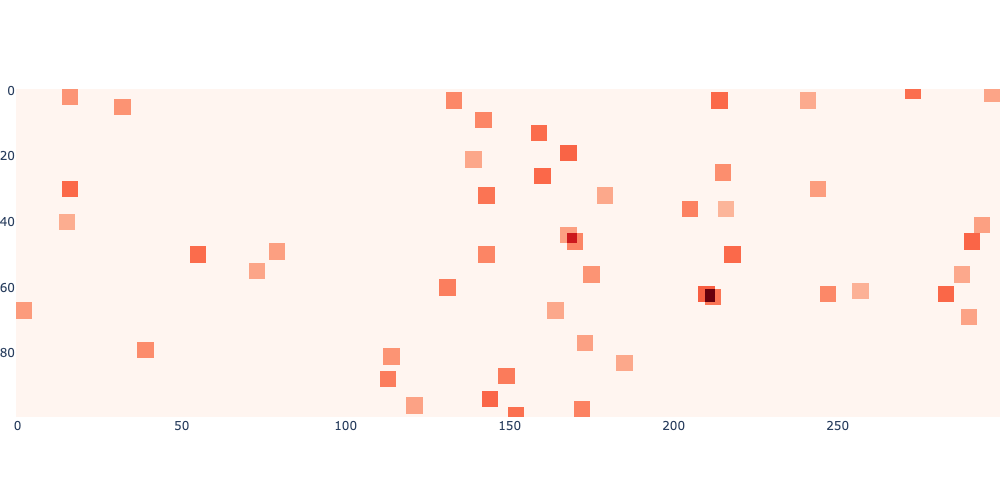

In [ ]:
# Create a random cost map
W, H = 30, 10  # 30m x 10m
cost_map = create_random_map(W, H, num_obstacles=50, seed=7)
fig = px.imshow(cost_map, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

## Gaussian Kernel

For smoothing the cost map and optimizing over it:

In [ ]:
#| export
def displaced_gaussian(
    sigma: float, K: int, uv: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns a Gaussian kernel of size K x K with standard deviation sigma.
    The kernel is centered at uv, a float coordinate in xy convention.
    Also returns the indices of the kernel in the image.
    """
    # Create meshgrid around uv, in ij convention
    j0, i0 = np.round(uv).astype(int)
    kk = np.arange(-(K // 2), K // 2 + 1)
    ii, jj = np.meshgrid(i0 + kk, j0 + kk, indexing="ij")

    # Calculate the kernel
    dd = (ii - uv[1]) ** 2 + (jj - uv[0]) ** 2
    kernel = np.exp(-dd / (2 * sigma**2))
    kernel = kernel / kernel.sum()

    # Return the kernel and the indices of the kernel in the image
    return kernel, ii, jj


def gaussian_kernel(sigma: float, K: int = 9) -> torch.Tensor:
    """Generates a Gaussian kernel of shape (1, 1, K, K) with standard deviation sigma."""
    uv = np.array([K // 2, K // 2])
    numpy_kernel, _, _ = displaced_gaussian(sigma, K, uv)
    return torch.tensor(numpy_kernel, dtype=torch.float32)[None, None, ...]


def gaussian_filter(sigma, uv, image, K=9):
    """Applies a Gaussian filter at uv on the given image."""
    kernel, ii, jj = displaced_gaussian(sigma, K, uv)
    
    # Dimensions of the image
    height, width = image.shape[-2:]

    # Find the valid range for ii and jj
    valid_mask = (ii >= 0) & (ii < height) & (jj >= 0) & (jj < width)
    valid_ii = ii[valid_mask]
    valid_jj = jj[valid_mask]

    # Adjust the kernel to match the valid range
    valid_kernel = kernel[valid_mask]

    # Extract the relevant portion of the image
    image_excerpt = image[..., valid_ii, valid_jj].numpy()

    # Apply the valid kernel to the image excerpt
    return (valid_kernel * image_excerpt).sum(axis=-1)

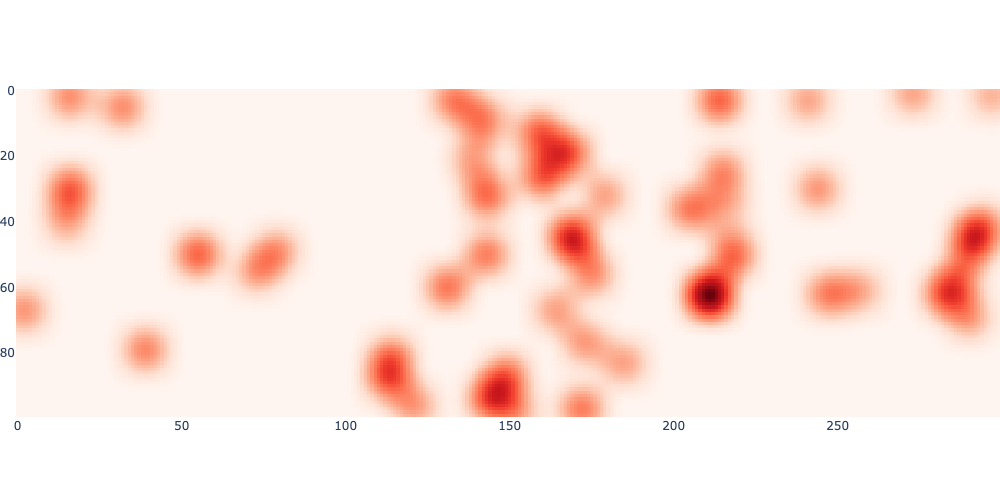

In [ ]:
sigma = 0.5  # 0.5m standard deviation for the Gaussian kernel
K = 21 # 21x21 kernel is big enough to accommodate that standard deviation 
kernel = gaussian_kernel(sigma*10, K) # multiply by 10 as map is 10cm resolution
batch = cost_map[None, None, ...]  # Add batch and channel dimensions
blurred = torch.conv2d(batch, kernel, padding='same')[0, 0, ...]
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

In [ ]:
xy = gtsam.Point2(7.5, 5.3) # point in map, in meters
uv = 10*xy # continuous position in image
local_result = gaussian_filter(sigma*10, uv, cost_map, K)
print(f"Local cost at {xy} is {local_result:.3f}")

# When uv are at integer values, blurred image gives the same result:
assert np.allclose(local_result, blurred[int(uv[1]), int(uv[0])])

Local cost at [7.5 5.3] is 0.135


In [ ]:
#| export
def sobel_kernels(dtype=torch.float32, **kwargs):
    """Return Sobel gradient kernels sobel_u of shape (1, 1, 1, 3) and sobel_v of shape (1, 1, 3, 1)."""
    sobel_u = torch.tensor([[-1, 0, 1]], dtype=dtype, **kwargs)
    sobel_v = sobel_u.T
    return sobel_u[None, None, ...], sobel_v[None, None, ...]

## Polynomial Smoothing

A small class to fit a pseudo-spectral Chebyshev basis:

In [ ]:
#| export
ChebyshevFactor = gtsam.VectorEvaluationFactorChebyshev2D3

class SmoothTrajectory:
    def __init__(self, path: np.array, N:int=5, a:float=-1, b:float=1, sample:bool = False, boundaries:bool = False):
        """
        Construct a polynomial fit of degree N-1, e.g. N=4 is a cubic.
        Args:
            path: An array of shape (K, 3) representing a 3D path.
            N: The number of control points.
            a: The lower bound of the time interval.
            b: The upper bound of the time interval.
            sample: If True, sample the path at N Chebyshev nodes of the second kind.
            boundaries: If True, constrain the start and end points to be constant velocity.
        """
        self.N, self.a, self.b = N, a, b
        assert path.shape[1] == 3, "Trajectory must be shape (K,3)"

        self.points = self.sample(path, N, a, b) if sample else self.fit(path, N, a, b, boundaries)

        # Cache differentiation matrices for velocities and accelerations:
        self.D = gtsam.Chebyshev2.DifferentiationMatrix(self.N, self.a, self.b)
        self.DD = self.D @ self.D

    @staticmethod
    def sample(path: np.array, N:int=5, a:float=-1, b:float=1):
        """Calculate N-2 Chebyshev nodes of the second kind in the [0,K-1] interval,
            and interpolate points at these Chebyshev nodes.
        """
        K = len(path)
        nodes = [gtsam.Chebyshev2.Point(N, i, 0, K-1) for i in range(1, N - 1)]
        middle = [path[int(t)] * (int(t) + 1 - t) + path[int(t) + 1] * (t - int(t)) for t in nodes]

        # Combine start point, middle points, and end point:
        return np.stack([path[0], *middle, path[-1]], axis=0)
    
    @staticmethod
    def fit(path: np.array, N:int=5, a:float=-1, b:float=1, boundaries:bool = False):
        """Fit basis using factor graph and adjusted weighting"""
        # Create factor graph
        K = len(path)
        constrained3 = gtsam.noiseModel.Constrained.All(3)
        graph = gtsam.NonlinearFactorGraph()
        t = np.linspace(a, b, K)
        x = np.linspace(-1.0, 1.0, K)
        key = 77
        for k, xyz in enumerate(path):
            t_k = t[k]
            if k == 0 or k == K - 1:
                model = constrained3 # constrained at end points
            else:
                precision = 1.0 / (1 - x[k]*x[k]) # high at ends, low in middle
                model = gtsam.noiseModel.Isotropic.Precision(3, precision)
            graph.add(ChebyshevFactor(key, xyz, model, N, t_k, a, b))
        
        # If asked, constrain start and end points to be constant velocity:
        if boundaries:
            dt = t[1] - t[0]
            v = (path[1] - path[0])/dt
            graph.add(ChebyshevFactor(key, path[0] - v*dt, constrained3, N, t[0]-dt, a, b))
            graph.add(ChebyshevFactor(key, path[0] - v*2*dt, constrained3, N, t[0]-2*dt, a, b))
            v = (path[-1] - path[-2])/dt
            graph.add(ChebyshevFactor(key, path[-1] + v*dt, constrained3, N, t[-1]+dt, a, b))
            graph.add(ChebyshevFactor(key, path[-1] + v*2*dt, constrained3, N, t[-1]+2*dt, a, b))
        
        # Optimize
        initial = gtsam.Values()
        initial.insert(key, gtsam.ParameterMatrix3(N))
        optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial)
        result = optimizer.optimize()
        return result.atParameterMatrix3(key).matrix().T

    def evaluate(self, t: np.ndarray):
        """Evaluate the polynomial at t, which should a 1D array."""
        weights = gtsam.Chebyshev2.WeightMatrix(self.N, t, self.a, self.b)
        return weights @ self.points

    def velocities(self, t: np.ndarray):
        """Evaluate the polynomial at t, which should a 1D array."""
        derivatives = self.D @ self.points
        weights = gtsam.Chebyshev2.WeightMatrix(self.N, t, self.a, self.b)
        return weights @ derivatives

    def accelerations(self, t: np.ndarray):
        """Evaluate the polynomial at t, which should a 1D array."""
        second_derivatives = self.DD @ self.points
        weights = gtsam.Chebyshev2.WeightMatrix(self.N, t, self.a, self.b)
        return weights @ second_derivatives

In [ ]:
# Create a random path of shape (K, 3):
rng = np.random.default_rng(seed=42)
K = 100
path = rng.random((K, 3))

T = 20.0
# exercise various options:
smooth = SmoothTrajectory(path, N=20, a=0, b=T, boundaries=True)
assert smooth.points.shape == (20, 3)
smooth = SmoothTrajectory(path, N=20, a=0, b=T, boundaries=False)
assert smooth.points.shape == (20, 3)
smooth = SmoothTrajectory(path, N=20, a=0, b=T, sample=True)
assert smooth.points.shape == (20, 3)


## Showing Trajectories

In [ ]:
#| export
def show_executed(desired_rn:np.ndarray, rn:np.ndarray, nRb: np.ndarray, K:int, step:int):
    """Show the executed trajectory in 3D."""
    fig = px.line_3d(x=rn[:K:step,0], y=rn[:K:step,1], z=rn[:K:step,2])
    fig.update_traces(line=dict(color='red'))
    fig.add_scatter3d(x=desired_rn[:K:step,0], y=desired_rn[:K:step,1], z=desired_rn[:K:step,2], mode='lines', line=dict(color='blue'))
    scale, labels = 0.1, ["F", "L", "U"]
    for k in range(0, K, 5):
        nTb = gtsam.Pose3(gtsam.Rot3(nRb[k]), rn[k])
        fig.add_traces(axes(nTb, scale, labels))
    fig.update_layout(scene_aspectmode='data', showlegend=False)
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
    return fig

## A Drone class

Combine the two classes in 7.2 into one dataclass for use in 7.5.

In [ ]:
#| export
@dataclass
class Drone:
    """A simple drone model with 6DOF dynamics."""

    # State
    rn: gtsam.Point3
    vn: gtsam.Point3
    nRb: gtsam.Rot3
    wb: gtsam.Point3

    # Parameters
    g: float = 9.81
    mass: float = 1.0
    k_d: float = 0.0425                        # drag coefficient
    I_xy: float = 4 * 0.15 * mass * 0.1**2     # All 4 motors contribute to I_xy
    I_z: float = 4 * 0.15 * mass * 2 * 0.1**2  # I_z leverages longer arm

    # Derived constants
    gn: np.ndarray = gtsam.Point3(0, 0, -g)    # gravity vector in navigation frame.
    I = np.diag([I_xy, I_xy, I_z])             # Inertia matrix

    def __repr__(self) -> str:
        return f"Drone:\nrn={self.rn}\nvn={self.vn}\nnRb={self.nRb}wb={self.wb}"

    def pose(self):
        """Return the current pose of the drone."""
        return gtsam.Pose3(self.nRb, self.rn)
        
    def integrate_thrust_vector(self, Tn: np.ndarray, dt=1.0):
        """Integrate a thrust vector in navigation frame."""
        # Calculate net force including gravity and drag:
        drag_force = -self.k_d * self.vn * np.linalg.norm(self.vn)
        net_force = Tn + self.gn + drag_force
        
        # Integrate force to update velocity navigation frame:
        self.vn += net_force * dt / self.mass

    def integrate_torque(self, tau:gtsam.Point3, dt=1.0):
        """Integrate equations of motion given dynamic inputs f and tau."""
        # rotational drag, assume 10x smaller linearly proportional to angular velocity:
        net_tau = tau - 0.1 * self.k_d * self.wb

        # Integrate angular velocity in body frame:
        self.wb[0] += net_tau[0] * dt / self.I_xy
        self.wb[1] += net_tau[1] * dt / self.I_xy
        self.wb[2] += net_tau[2] * dt / self.I_z

    def integrate_kinematics(self, dt):
        """Integrate kinematics given current velocities vn and wb."""
        self.rn += self.vn * dt  # integrate position
        # calculate incremental rotation matrix using the exponential map
        dR = gtsam.Rot3.Expmap(self.wb * dt)
        self.nRb = self.nRb * dR  # integrate attitude
        
    def integrate(self, f: float, tau:gtsam.Point3, dt=1.0):
        """Integrate equations of motion given dynamic inputs f and tau."""
        # Calculate thrust vector in navigation frame and integrate:
        Tn = self.nRb.rotate(gtsam.Point3(0, 0, f))
        self.integrate_thrust_vector(Tn, dt)

        # integrate torque:
        self.integrate_torque(tau, dt)
        
        # Integrate kinematics
        self.integrate_kinematics(dt)


A drone pitching and accelerating forwards:

Drone:
rn=[1.72976768 0.         0.        ]
vn=[1.72976768 0.         0.        ]
nRb=R: [
	0.984808, 0, 0.173648;
	0, 1, 0;
	-0.173648, 0, 0.984808
]
wb=[0. 0. 0.]


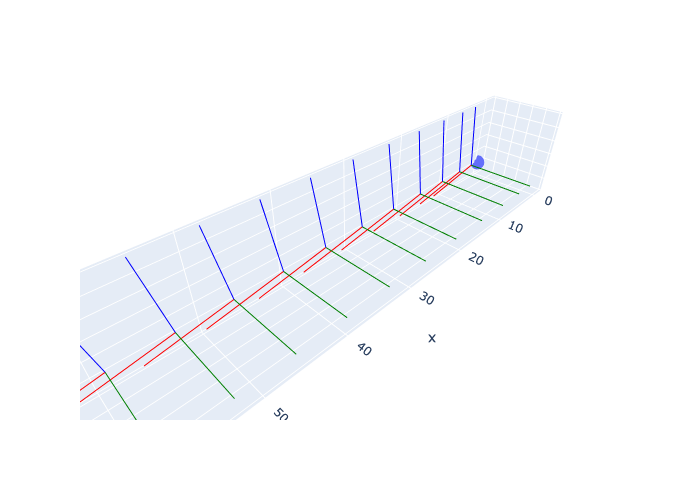

In [ ]:
zero = lambda : gtsam.Point3(0, 0, 0)
pitch = math.radians(10)
f = 9.81 / math.cos(pitch)
drone = Drone(rn=zero(), vn=zero(), nRb=gtsam.Rot3.Pitch(pitch), wb=zero())

drone.integrate(f, zero(), dt=1)
print(drone)
assert np.allclose(drone.rn, gtsam.Point3(1.72976768, 0, 0))
assert np.allclose(drone.vn, gtsam.Point3(1.72976768, 0, 0))
assert np.allclose(drone.wb, gtsam.Point3(0, 0, 0))

fig = px.scatter_3d(x=[0], y=[0], z=[0])
scale, labels = 10, ["F", "L", "U"]
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.integrate(f, zero(), dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()